In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from utils import setup_seed
import matplotlib.pyplot as plt
from tqdm import tqdm
from models import resnet18_c
import torch.optim.lr_scheduler as lr_scheduler
from pathlib import Path
from datetime import datetime
import orjson

In [8]:
# -------------------------
# 2. PACR Loss (batch-wise)
# -------------------------
def pacr_loss(features, labels):
    """
    features: (B, D)
    labels:   (B,)
    """
    loss = 0.0
    num_classes = labels.max().item() + 1
    eps = 1e-8

    for c in range(num_classes):
        idx = labels == c
        if idx.sum() < 2:
            continue
        z = features[idx]  # (Nc, D)
        mean = z.mean(dim=0, keepdim=True)
        loss += ((z - mean) ** 2).sum(dim=1).mean()

    return loss / (num_classes + eps)


In [9]:
# -------------------------
# 3. Training / Evaluation
# -------------------------
def train_epoch(model, loader, optimizer, device, lambda_pacr=0.0):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, feats = model(x, return_feat=True)
        loss_ce = F.cross_entropy(logits, y)

        loss = loss_ce
        if lambda_pacr > 0:
            loss_pacr = pacr_loss(feats, y)
            loss = loss + lambda_pacr * loss_pacr

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total


In [10]:
@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_correct, total = 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_correct / total


In [ ]:
# -------------------------
# 4. Main Experiment
# -------------------------
def main(lambda_pacr=0.0, epochs=200):  # 建议增加到 200
    info = {"train_acc": [], "test_acc": []}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. 修正为 CIFAR-10 特定的标准化参数
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std = (0.2023, 0.1994, 0.2010)

    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
        ]
    )

    # 2. 修正：测试集也必须进行相同的标准化
    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
        ]
    )

    train_set = datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    test_set = datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=256)

    model = resnet18_c().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9, weight_decay=5e-4)

    # 3. 加入 Cosine Annealing 调度器
    # T_max 通常设置为总的训练epoch数
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, device, lambda_pacr
        )
        test_acc = eval_epoch(model, test_loader, device)

        # 4. 更新学习率
        scheduler.step()

        info["train_acc"].append(train_acc)
        info["test_acc"].append(test_acc)

        # 可选：记录当前学习率，观察是否符合余弦下降
        # current_lr = optimizer.param_groups[0]['lr']

    return info

In [ ]:
setup_seed(2, deterministic=True)

ainfo = main(lambda_pacr=0.005, epochs=20)


100%|██████████| 20/20 [18:32<00:00, 55.64s/it]


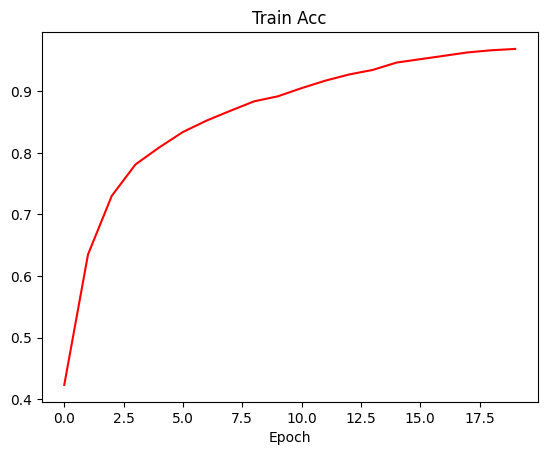

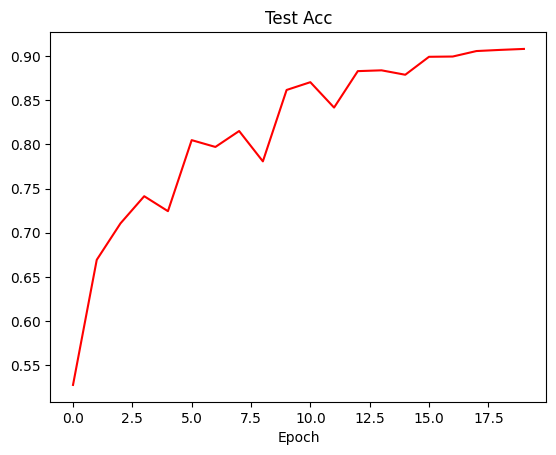

In [13]:
fig, ax = plt.subplots()
ax.plot(ainfo["train_acc"], "r")
ax.set_xlabel("Epoch")
ax.set_title("Train Acc")
plt.show()
fig, ax = plt.subplots()
ax.plot(ainfo["test_acc"], "r")
ax.set_xlabel("Epoch")
ax.set_title("Test Acc")
plt.show()


In [14]:
np.max(ainfo["test_acc"]), np.mean(ainfo["test_acc"])


(np.float64(0.9078), np.float64(0.815355))

In [15]:
ainfo["test_acc"][-1]

0.9078

In [24]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# datetime.now().strftime("%Y-%m-%d %H:%M:%S")
config = {
    "lambda_pacr": 0.005,
    "epochs": 20,
    "dataset": "CIFAR-10",
    "model": "ResNet18",
    "optimizer": "SGD",
    "learning_rate": 0.04,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "batch_size_train": 512,
    "batch_size_test": 256,
    "date": timestamp,
}
save_dir = Path("results") / timestamp
save_dir.mkdir(parents=True, exist_ok=True)
file_path = save_dir / "reg.json"
with open(file_path, "wb") as f:
    f.write(
        orjson.dumps(
            {
                "config": config,
                "ainfo": ainfo,
            },
            option=orjson.OPT_INDENT_2,
        )
    )